# Movie Recommendation - Mission 1

### Movielense Dataset EDA


EDA(Exploratory Data Analysis)는 데이터셋을 다양한 각도에서 관찰하고 인사이트를 얻을 수 있는 중요한 데이터 분석 과정입니다. 이를 잘 수행하여 데이터의 특징과 분포에 대해 깊은 이해도를 가진다면, 모델의 성능에도 큰 영향을 끼칠 수 있습니다.

본 미션에서는 Movie Recommendation 대회를 위해 제공되는 [movielens](https://grouplens.org/datasets/movielens/) 를 재구성한 대회 데이터셋에 대한 EDA를 진행하고, 학습 데이터에 더불어 영화의 side-information 데이터에 대해 이해하는 시간을 가져보겠습니다!

## 확인할 것들
- 시리즈 여부

- writer별 특성을 잡아내면 좋을 것 같음
    - writer가 참여한 영화들 사이의 관계를 알아보자
<br><br>

- director별 특성을 잡아내면 좋을 것 같음
    - director가 참여한 영화들 사이의 관계를 알아보자
    - director별 영화의 수
    - director별 영화의 수를 binning하여 
<br><br>
- 시간대별 장르의 선호

<br><br>
- 

## 대회 데이터셋 구성
먼저 데이터셋의 구성을 살펴봅니다.

### data
    ├── directors.tsv
    ├── genres.tsv
    ├── titles.tsv
    ├── train_ratings.csv
    ├── writers.tsv
    └── years.tsv
    
1. *train_ratings.csv* : 전체 훈련 데이터.
2. *directors.tsv*, *genres.tsv*, *writers.tsv*, *years.tsv*, *titles.tsv* : 영화의 side-information 데이터.

## train/test 데이터셋 알아보기

Pandas를 이용하여 train 데이터를 로드하고 데이터 구성을 알아봅니다. 이어지는 코드를 실행하면 데이터셋의 간략한 정보와 샘플을 확인할 수 있습니다.

train 데이터셋은 *user, item, time* 세개의 column으로 구성된 반면, test 데이터셋은 *user* column과 비어있는 *item* column으로 구성되어 있음을 참고해 주세요. 대회 진행시, 각각의 사용자에게 10개의 영화를 추천하게 됩니다.

각 column은 다음을 나타냅니다.
- *user*: 사용자 id.
- *item*: 영화 id.
- *time*: 사용자가 해당 영화와 interact한 시간. (UNIX시간의 초 단위)

영화 id는 *directors.tsv, genres.tsv, writers.tsv, years.tsv, titles.tsv*에서도 일관적으로 사용됩니다. 즉, 동일한 영화 id는 side information 데이터셋에서 동일한 영화를 나타냅니다.

이어지는 cell들을 실행해서 직접 관찰해보세요!

## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요. 
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [1]:
!wget <대회 데이터 URL>
!tar -xf data.tar.gz

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `wget <대회 데이터 URL>'
tar: data.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /opt/ml/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /opt/ml/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
data_path = './data/train'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

In [8]:
train_df.info()
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [9]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)

Number of unique train users:  31360
Number of unique train items:  6807


In [10]:
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Data sparsity ratio:  0.9758536052697853


데이터의 sparsity ratio는 약 97.6%로 일반적인 추천 시스템 데이터셋에 비해 굉장히 dense한 (행렬 상 이력의 많은 부분이 채워져 있는) 데이터임을 알 수 있습니다.

## Side Information 알아보기

다음은 side information 데이터를 알아봅니다. 일반적으로 추천시스템에서는 side information을 더욱 잘 활용할수록 더 좋은 추천 결과를 얻을 수 있게 됩니다.

주어진 year, writer, title, genre, director 데이터를 불러옵니다. 마찬가지로 각 데이터의 간략한 정보를 확인하고 샘플을 미리 저장해보겠습니다. 샘플된 데이터는 뒤에서도 계속 사용할 예정인 점을 참고해주세요! 그럼 다음 코드를 실행해보겠습니다.

In [11]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

그러면 먼저 *years.tsv* 데이터를 알아보겠습니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *year* : 해당 영화가 개봉한 연도.

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

그리고 바로 이어지는 cell을 실행하여 추가적인 통계도 확인합니다. 데이터셋에 한 번 이상 출현하는 영화 작품은 총 6799편이며 평균 개봉 연도는 1992년인 등의 정보를 파악할 수 있습니다.

*year*는 1922년부터 2014년까지 분포하고 있습니다. 1979년을 시작으로 영화가 많이 만들어지기 시작합니다.

이는 영화 산업이 활발해 지는 시기부터 영화 제작이 많아진 것으로 생각되고, 데이터의 분포가 롱테일로 나타나게 됩니다.

In [12]:
year_data.info()
year_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923


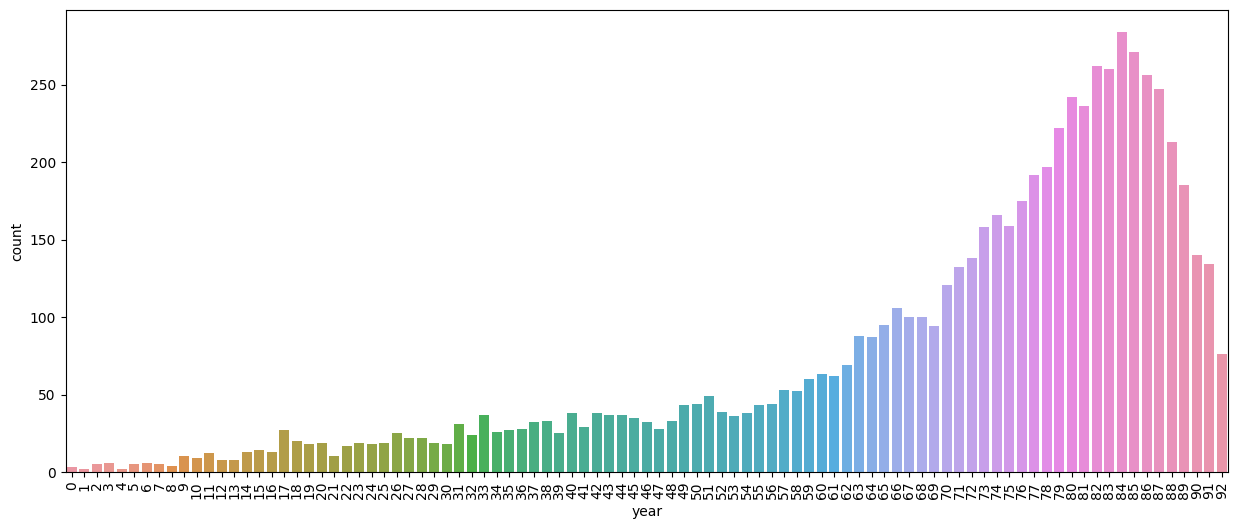

In [14]:
year2idx = {year : idx for idx, year in enumerate(year_data['year'].unique())}
idx2year = {idx : year for year, idx in year2idx.items()}
tmp = year_data.sort_values(by=['year'])
tmp['year'] = tmp['year'].map(year2idx)
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
sns.countplot(data=tmp, x='year')
plt.show()

In [15]:
year_count = tmp.groupby(by=['year']).count()
tmp

,item,year
0,1348,0
1,44587,0
2,4768,0
3,8235,1
4,8609,1
...,...,...
6744,118696,92
6743,111759,92
6742,114342,92
6749,109487,92


In [16]:
yearcount = {idx : count for idx, count in enumerate(year_count.item.values)}
tmp['year_count'] = tmp['year'].map(yearcount)
tmp

,item,year,year_count
0,1348,0,3
1,44587,0,3
2,4768,0,3
3,8235,1,2
4,8609,1,2
...,...,...,...
6744,118696,92,76
6743,111759,92,76
6742,114342,92,76
6749,109487,92,76


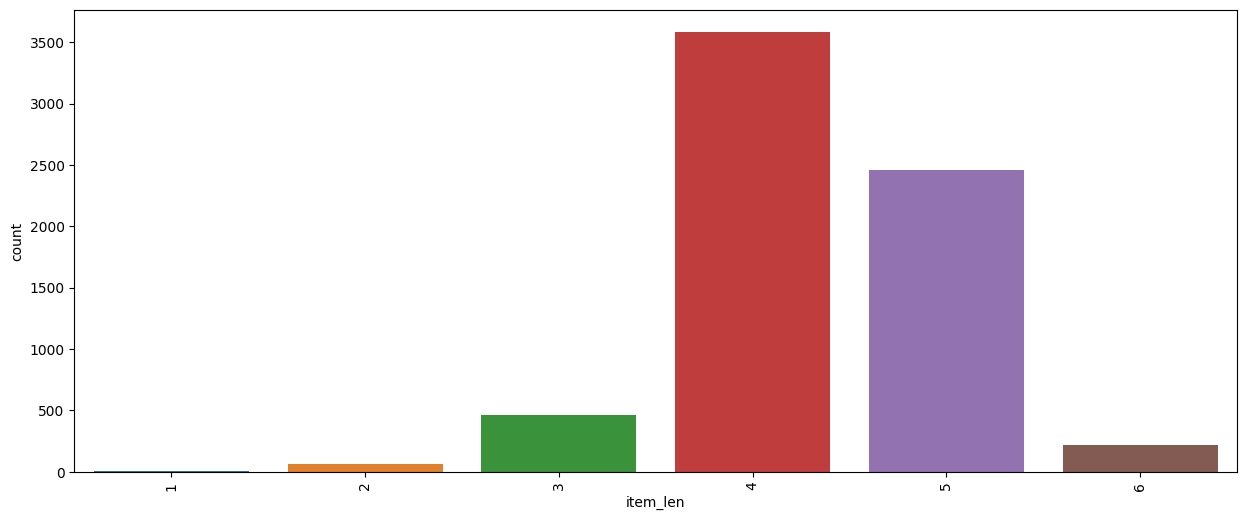

In [17]:
tmp['item_len'] = tmp['item'].apply(lambda x : len(str(x)))
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
sns.countplot(data=tmp, x='item_len')
plt.show()

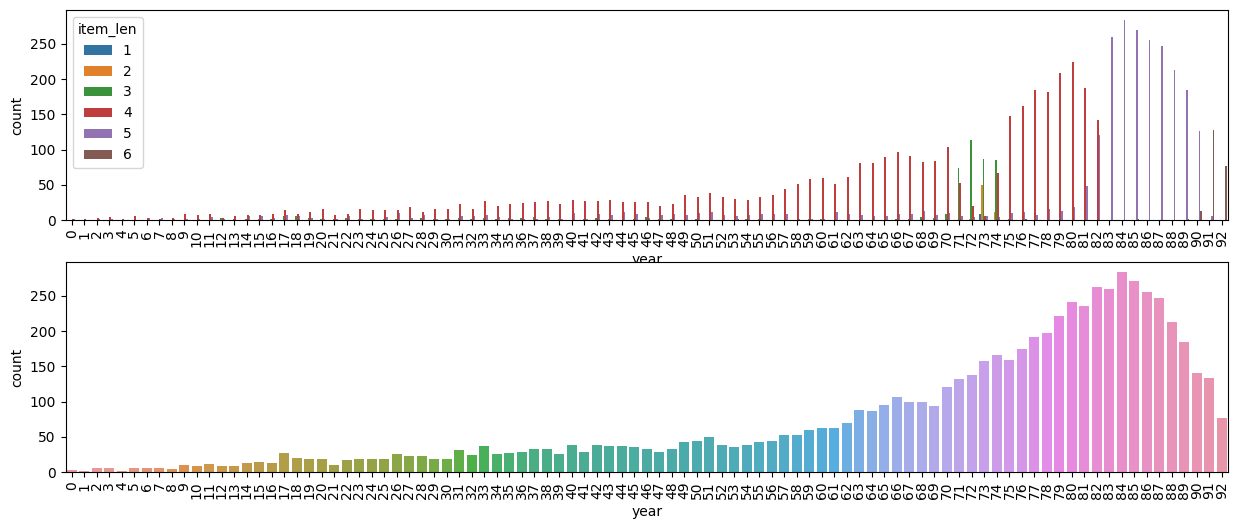

In [18]:
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.xticks(rotation=90)
sns.countplot(data=tmp, x='year', hue='item_len')

plt.subplot(2, 1, 2)
plt.xticks(rotation=90)
sns.countplot(data=tmp, x='year')
plt.show()

In [19]:
print ("Year data shape: ", year_data.shape)
print("Number of unique items in year_df: ", year_data['item'].nunique())
print("Number of unique years: ", year_data['year'].nunique())
print ("\nStatistics of year data: ")
year_data['year'].describe()

Year data shape:  (6799, 2)
Number of unique items in year_df:  6799
Number of unique years:  93

Statistics of year data: 


count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

다음은 *writers.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *writer* : 영화의 각본가. (익명화)

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

그리고 바로 이어지는 cell을 실행하여 추가적인 통계도 확인합니다. 데이터셋에 한 번 이상 출현하는 영화 작품은 총 6799편이며 평균 개봉 연도는 1992년인 등의 정보를 파악할 수 있습니다.

*year*는 1922년부터 2014년까지 분포하고 있습니다. 1979년을 시작으로 영화가 많이 만들어지기 시작합니다.

이는 영화 산업이 활발해 지는 시기부터 영화 제작이 많아진 것으로 생각되고, 데이터의 분포가 롱테일로 나타나게 됩니다.

In [20]:
writer_data.info()
writer_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


,item,writer
0,1237,nm0000005
1,5147,nm0000005


In [21]:
print ("Year data shape: ", writer_data.shape)
print("Number of unique items in writer_data: ", writer_data['item'].nunique())
print("Number of unique wirters: ", writer_data['writer'].nunique())
print ("\nStatistics of writer data: ")
writer_data['writer'].describe()

Year data shape:  (11306, 2)
Number of unique items in writer_data:  5648
Number of unique wirters:  2989

Statistics of writer data: 


count         11306
unique         2989
top       nm0000095
freq             47
Name: writer, dtype: object

앞 두자리가 의미가 있는지 확인합니다.

확인결과 단일 값으로 의미가 없습니다.

In [22]:
writer_data.writer.apply(lambda x: x[:2]).unique()

array(['nm'], dtype=object)

writer당 item의 수가 얼마나 되는지 확인합니다.

가장 적은 수의 item을 만든 writer는 2개이고, 가장 많은 수의 item을 만든 writer는 47개입니다.

평균적으로는 3.8개 정도를 만드는 모습을 보이며 중앙값인 3과의 차이가 크지 않습니다.

또한 4개 이상의 item을 만든 writer는 25%입니다.

In [23]:
writer_per_item = writer_data.groupby(by=['writer'], as_index=False).count()
writer_per_item

,writer,item
0,nm0000005,18
1,nm0000019,10
2,nm0000033,5
3,nm0000036,2
4,nm0000040,11
...,...,...
2984,nm5022110,5
2985,nm5335213,2
2986,nm5371819,3
2987,nm5927607,2


전체 writer 중 
24%가 5개 이상, 4.15%가 10개 이상, 1.03%가 15개 이상, 0.4%가 20개 이상을 만들었습니다.

In [24]:
print(f"5개 이상 비율 : {720 / 2989 * 100}")
print(f"10개 이상 비율 : {124 / 2989 * 100}")
print(f"15개 이상 비율 : {37 / 2989 * 100}")
print(f"20개 이상 비율 : {12 / 2989 * 100}")

5개 이상 비율 : 24.088323854131815
10개 이상 비율 : 4.148544663767146
15개 이상 비율 : 1.2378721980595517
20개 이상 비율 : 0.4014720642355303


In [25]:
print(len(writer_per_item.loc[(writer_per_item['item'] >= 0) & (writer_per_item['item'] <= 5)]))
print(len(writer_per_item.loc[(writer_per_item['item'] >= 6) & (writer_per_item['item'] <= 10)]))
print(len(writer_per_item.loc[(writer_per_item['item'] >= 11) & (writer_per_item['item'] <= 15)]))
print(len(writer_per_item.loc[(writer_per_item['item'] >= 15) & (writer_per_item['item'] <= 20)]))

2480
416
62
27


In [26]:
writer_per_item.describe()

,item
count,2989.000000
mean,3.782536
std,2.993783
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,47.000000


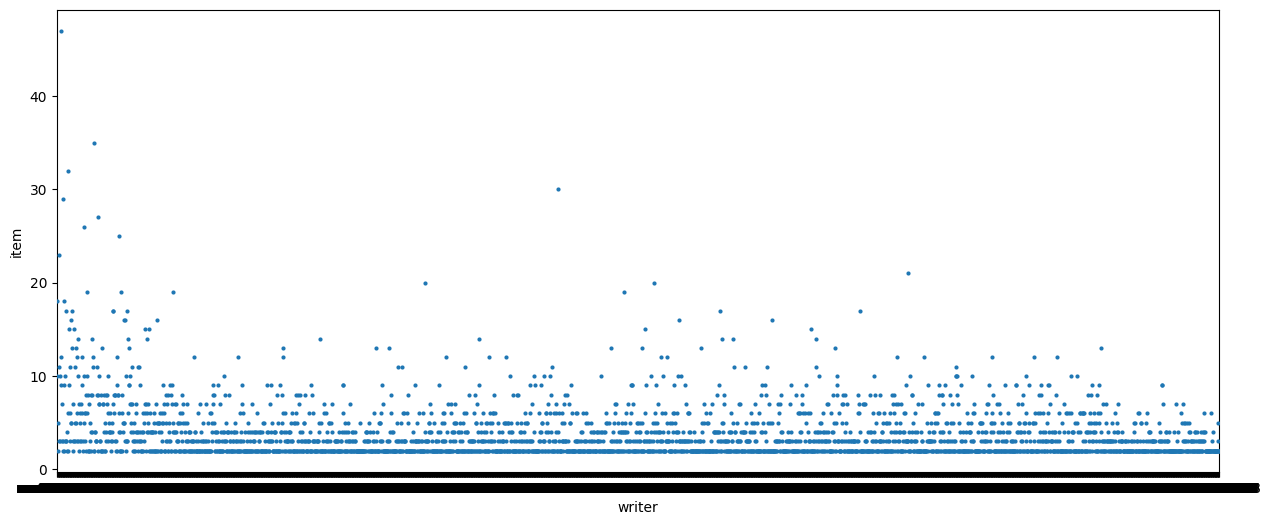

In [27]:
plt.figure(figsize=(15, 6))
sns.swarmplot(data=writer_per_item, x='writer', y='item', size=3)
plt.show()

In [46]:
writer_per_item

,writer,item
0,nm0000005,18
1,nm0000019,10
2,nm0000033,5
3,nm0000036,2
4,nm0000040,11
...,...,...
2984,nm5022110,5
2985,nm5335213,2
2986,nm5371819,3
2987,nm5927607,2


In [52]:
joint_data = writer_data.merge(genre_data, on="item")
joint_data.groupby(by=["writer", "genre"], as_index=False).count()

,writer,genre,item
0,nm0000005,Comedy,2
1,nm0000005,Drama,16
2,nm0000005,Fantasy,2
3,nm0000005,Horror,1
4,nm0000005,Musical,1
...,...,...,...
14356,nm5927608,Children,2
14357,nm5927608,Comedy,2
14358,nm5927608,Crime,1
14359,nm5927608,Fantasy,2


In [56]:
writer_per_item.sort_values(by='item', ascending=False)[:10]
writer_per_item.sort_values(by=)

,writer,item
11,nm0000095,47
96,nm0000636,35
28,nm0000175,32
1287,nm0372942,30
14,nm0000108,29
104,nm0000697,27
68,nm0000455,26
160,nm0001220,25
5,nm0000041,23
2188,nm0744429,21


In [61]:
joint_data

,item,writer,genre
0,1237,nm0000005,Drama
1,5147,nm0000005,Drama
2,7327,nm0000005,Drama
3,2068,nm0000005,Drama
4,2068,nm0000005,Fantasy
...,...,...,...
31506,100302,NaN,Sci-Fi
31507,65193,NaN,Drama
31508,65193,NaN,Romance
31509,4219,NaN,Comedy


In [60]:
import plotly.express as px

# joint_data = writer_per_item#.merge(genre_data, on="item")
joint_data = writer_data.merge(genre_data, on="item", how="outer")

# joint_data = joint_data.sort_values(by='item', ascending=False)
# top_rated=joint_data[0:10]
# # top_rated
# fig =px.sunburst(
#     top_rated,
#     path=['genre', 'writer'],
#     values='item',
#     color='item')
# fig.show()

다음은 *titles.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *titles* : 영화 제목.

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [29]:
title_data.info()
title_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
2,2959,Fight Club (1999)
3,296,Pulp Fiction (1994)
4,356,Forrest Gump (1994)


title_data의 *title* 컬럼에도 연도에 대한 정보가 있습니다.

이것과 year_data의 *year*와 상이한 부분이 있는지 확인해보겠습니다.

확인 결과 모두 동일한 것으로 확인됩니다.

In [30]:
import re
title_year_data = pd.merge(title_data, year_data, on="item")
title_year_data['refine_title'] = title_year_data['title'].apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
title_year_data['refine_title'] = title_year_data['refine_title'].apply(lambda x: re.sub(' +', ' ', x))
title_year_data['title_year'] = title_year_data['refine_title'].apply(lambda x: int(x.strip()[-4:]))
title_year_data.loc[title_year_data['title_year'] != title_year_data['year']]

,item,title,year,refine_title,title_year
5197,108583,Fawlty Towers (1975-1979),1975,Fawlty Towers 1975 1979,1979


In [31]:
def munge_title(title):
    for suff_word in ['the', 'a', 'an']:
        suffix = ', {}'.format(suff_word)
        if title.endswith(suffix):
            title = suff_word + ' ' + title[:-len(suffix)]
    return title

title_data['refine_title'] = title_data['title'].apply(lambda x: re.sub('\([^)]*\)', ' ', x).strip().lower())
title_data['refine_title'] = title_data['refine_title'].apply(lambda x: re.sub(' +', ' ', x))
title_data['refine_title'] = title_data['refine_title'].apply(lambda x: munge_title(x).strip())
title_data['refine_title'] = title_data['refine_title'].apply(lambda x: re.sub("[^a-z0-9]", ' ', x).strip())
title_data

,item,title,refine_title
0,318,"Shawshank Redemption, The (1994)",the shawshank redemption
1,2571,"Matrix, The (1999)",the matrix
2,2959,Fight Club (1999),fight club
3,296,Pulp Fiction (1994),pulp fiction
4,356,Forrest Gump (1994),forrest gump
...,...,...,...
6802,73106,American Pie Presents: The Book of Love (Ameri...,american pie presents the book of love
6803,109850,Need for Speed (2014),need for speed
6804,8605,Taxi 3 (2003),taxi 3
6805,3689,Porky's II: The Next Day (1983),porky s ii the next day


In [28]:
title_data['refine_title_len'] = title_data['refine_title'].apply(lambda x: len(x))
title_data['refine_title_len'].describe()

count    6807.000000
mean       15.723226
std         8.569919
min         1.000000
25%        10.000000
50%        14.000000
75%        19.000000
max        83.000000
Name: refine_title_len, dtype: float64

In [29]:
mean_len = title_data['refine_title_len'].value_counts().to_frame().sort_index()['refine_title_len'].mean()

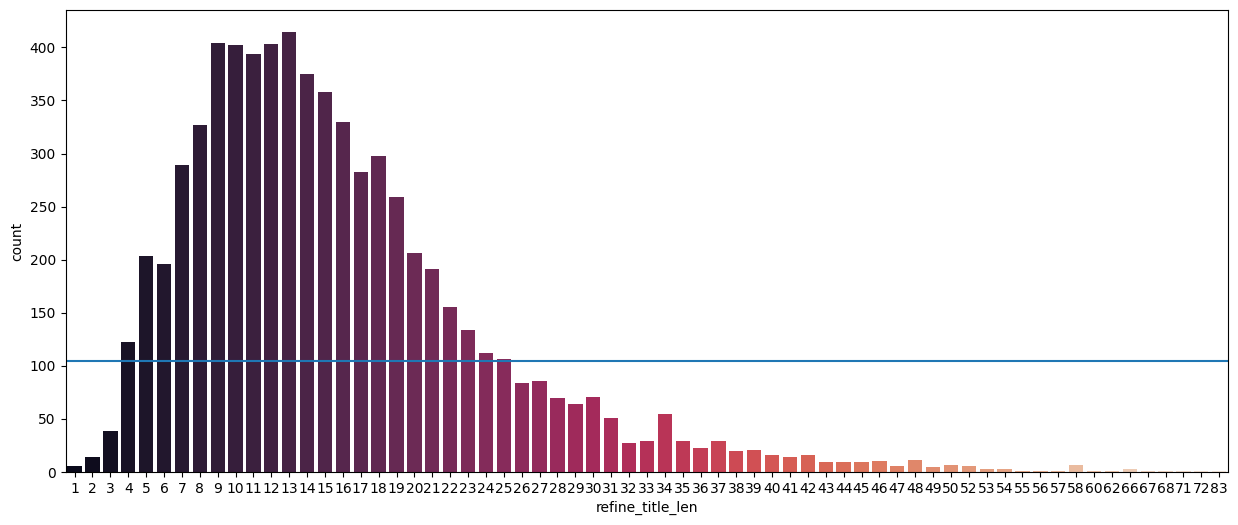

In [30]:
plt.figure(figsize=(15, 6))
sns.countplot(data=title_data, x='refine_title_len', palette='rocket')
plt.axhline(mean_len)
plt.show()

다음은 *genres.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *genre* : 영화의 장르.

하나의 영화는 여러 개의 장르를 가질 수 있습니다.
다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [33]:
genre_data.info()
genre_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    15933 non-null  int64 
 1   genre   15933 non-null  object
dtypes: int64(1), object(1)
memory usage: 249.1+ KB


,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller


In [34]:
genre_per_item = genre_data.groupby(by=['genre'], as_index=False).count()
genre_per_item

,genre,item
0,Action,1246
1,Adventure,891
2,Animation,355
3,Children,432
4,Comedy,2408
5,Crime,924
6,Documentary,323
7,Drama,3490
8,Fantasy,557
9,Film-Noir,97


In [35]:
genre_per_item.describe()

,item
count,18.000000
mean,885.166667
std,866.208252
min,97.000000
25%,348.250000
50%,579.500000
75%,1165.500000
max,3490.000000


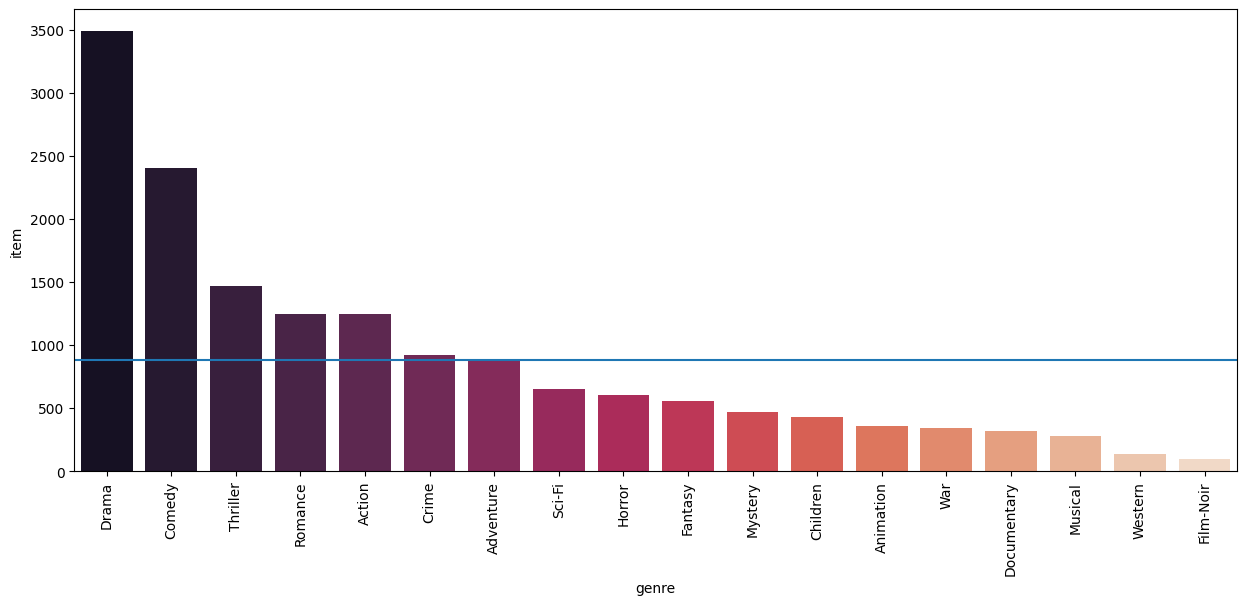

In [36]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
plt.axhline(genre_per_item['item'].mean())
sns.barplot(data=genre_per_item.sort_values(by="item", ascending=False), x='genre',y='item', palette='rocket')
plt.show()

In [65]:
import plotly.express as px

joint_data = genre_per_item.merge(year_data, on="item")
joint_data = joint_data.sort_values(by='item', ascending=False)
joint_data['count'] = 1
top_rated=joint_data
# top_rated
fig =px.sunburst(
    top_rated,
    path=['year', 'genre'],
    values='count',
    color='count')
fig.show()

In [77]:
pd.qcut(genre_per_item['item'], 10)

0      (920.7, 1249.0]
1       (700.6, 920.7]
2       (332.2, 362.7]
3       (362.7, 463.2]
4     (1748.6, 3490.0]
5      (920.7, 1249.0]
6       (239.1, 332.2]
7     (1748.6, 3490.0]
8       (463.2, 579.5]
9      (96.999, 239.1]
10      (579.5, 700.6]
11      (239.1, 332.2]
12      (463.2, 579.5]
13    (1249.0, 1748.6]
14      (579.5, 700.6]
15    (1249.0, 1748.6]
16      (332.2, 362.7]
17     (96.999, 239.1]
Name: item, dtype: category
Categories (10, interval[float64, right]): [(96.999, 239.1] < (239.1, 332.2] < (332.2, 362.7] < (362.7, 463.2] ... (700.6, 920.7] < (920.7, 1249.0] < (1249.0, 1748.6] < (1748.6, 3490.0]]

마지막으로 *directors.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *director* : 영화 감독. (익명화)

하나의 영화는 여러 명의 감독을 가질 수 있습니다. 다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [32]:
director_data.info()
director_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item      5905 non-null   int64 
 1   director  5905 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005


## 데이터 시각화 해보기
앞에서 주어진 데이터셋을 먼저 간단히 살펴보았습니다. 이제부터는 다수의 파일을 merge하여 시각화하고, 데이터에 대해 좀 더 깊은 이해를 해보겠습니다.

먼저 효율적인 데이터 시각화를 위해, 데이터셋에서 빈도수가 높은 movie, user 데이터의 id를 미리 저장하겠습니다.
train 데이터에서 데이터의 출현 빈도 순으로 *active_user_ids*와 *popular_movie_ids*에 top 10을 각각 저장합니다.

대회 데이터셋에서 빈도수가 높을수록 유명한 영화를 나타내는 것은 아니지만, 편의상 *popular_movie_id* 변수명을 사용하는 점을 당부드립니다.

다음 코드를 실행해주세요.

In [33]:
active_user_ids = train_df.value_counts('user').index[:10]
popular_movie_ids = train_df.value_counts('item').index[:10]

print ("active user ids: ", active_user_ids)
print ("\npopular movie ids: ", popular_movie_ids)

active user ids:  Int64Index([8405, 54465, 24219, 32514, 91349, 131904, 34576, 99754, 31122,
            118754],
           dtype='int64', name='user')

popular movie ids:  Int64Index([2571, 2959, 296, 318, 356, 4993, 7153, 5952, 593, 2858], dtype='int64', name='item')


*active_user_ids*와 *popular_movie_ids*에 각각 빈도가 높은 영화와 사용자 id들을 저장했습니다. 뒤에서도 계속 사용할 예정이니 참고해 주세요.

이제부터는 train 데이터와 side information 데이터를 merge하고, side information 별 user-item 빈도수가 높은 데이터 샘플을 미리 저장합니다. 위에서 저장한 active user id와 popular movie id와 다르게 여기서는 바로 Pandas Dataframe의 형태로 샘플을 저장합니다. 빈도가 가장 높은 10개 side information data가 해당하는 모든 user-item interaction를 저장할 것이므로, 각 side information 데이터 샘플의 크기는 상이합니다.

이어지는 코드 cell들을 실행해보고, 출력된 결과를 충분히 관찰해보시기 바랍니다.

In [34]:
director_df = pd.merge(train_df, director_data, on=['item'])
director_id = director_df.value_counts('director').index[:10]

side_df = []
for director in director_id:
    side_df.append(director_df.loc[director_df['director'] == director])

director_top = pd.concat(side_df)

print ("Number of all unique director ids: ", director_df['director'].nunique())
print ("\ntop 10 director ids: \n", director_id)
print ("\nsample of top 10 user-director data: \n", director_top.sample(5))
print ("\nshape of the data: ", director_top.shape)

Number of all unique director ids:  1340

top 10 director ids: 
 Index(['nm0000229', 'nm0000233', 'nm0634240', 'nm0000709', 'nm0001392',
       'nm0000217', 'nm0001054', 'nm0000116', 'nm0000399', 'nm0000631'],
      dtype='object', name='director')

sample of top 10 user-director data: 
            user   item        time   director
1505739  106614  48516  1176872306  nm0000217
202440    32094   1255  1347727177  nm0001392
2192803   65171    111  1204085724  nm0000217
3605468  106193  48780  1219005879  nm0634240
2448147  118845  72998  1293058097  nm0000116

shape of the data:  (672019, 4)


In [35]:
writer_df = pd.merge(train_df, writer_data, on=['item'])
writer_id = writer_df.value_counts('writer').index[:10]

side_df = []
for writer in writer_id:
    side_df.append(writer_df.loc[writer_df['writer'] == writer])

writer_top = pd.concat(side_df)

print ("Number of all unique writer ids: ", writer_df['writer'].nunique())
print ("\ntop 10 writer ids: \n", writer_id)
print ("\nsample of top 10 user-writer data: \n", writer_top.sample(5))
print ("\nshape of the data: ", writer_top.shape)

Number of all unique writer ids:  2989

top 10 writer ids: 
 Index(['nm0000184', 'nm0000233', 'nm0634240', 'nm0001392', 'nm0909638',
       'nm0004056', 'nm0744429', 'nm0101991', 'nm0254645', 'nm0000175'],
      dtype='object', name='writer')

sample of top 10 user-writer data: 
            user   item        time     writer
3524325  114181    588  1288064092  nm0254645
6748791  109460    247  1270924129  nm0001392
4086245   90242   8360  1122051942  nm0254645
4090253   97249   8360  1201457576  nm0254645
7458675   47640  78499  1343731860  nm0004056

shape of the data:  (651286, 4)


In [36]:
title_df = pd.merge(train_df, title_data, on=['item'])
title_id = title_df.value_counts('title').index[:10]


side_df = []
for title in title_id:
    side_df.append(title_df.loc[title_df['title'] == title])

title_top = pd.concat(side_df)

print ("Number of all unique movie titles: ", title_df['title'].nunique())
print ("\ntop 10 movie titles: \n", title_id)
print ("\nsample of top 10 user-title data: \n", title_top.sample(5))
print ("\nshape of the data: ", title_top.shape)

Number of all unique movie titles:  6806

top 10 movie titles: 
 Index(['Matrix, The (1999)', 'Fight Club (1999)', 'Pulp Fiction (1994)',
       'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)',
       'Lord of the Rings: The Fellowship of the Ring, The (2001)',
       'Lord of the Rings: The Return of the King, The (2003)',
       'Lord of the Rings: The Two Towers, The (2002)',
       'Silence of the Lambs, The (1991)', 'American Beauty (1999)'],
      dtype='object', name='title')

sample of top 10 user-title data: 
            user  item        time  \
229864    51784  2571  1144801869   
1368486   11625  7153  1182074512   
1380280  109620  7153  1401888989   
227232    33647  2571  1138404041   
818763   133567  2959  1228994512   

                                                     title  \
229864                                  Matrix, The (1999)   
1368486  Lord of the Rings: The Return of the King, The...   
1380280  Lord of the Rings: The Return of the King, The.

In [37]:
year_df = pd.merge(train_df, year_data, on=['item'])
year_id = year_df.value_counts('year').index[:10]

side_df = []
for year in year_id:
    side_df.append(year_df.loc[year_df['year'] == year])

year_top = pd.concat(side_df)

print ("All unique years: \n", np.sort(year_df['year'].unique())) 
print ("\nNumber of all unique years: ", year_df['year'].nunique())
print ("\ntop 10 years: \n", year_id)
print ("\nsample of top 10 user-year data: \n", year_top.sample(5))
print ("\nshape of the data: ", year_top.shape)

All unique years: 
 [1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935
 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014]

Number of all unique years:  93

top 10 years: 
 Int64Index([2004, 1999, 2001, 2002, 2006, 2003, 2000, 2005, 1995, 2007], dtype='int64', name='year')

sample of top 10 user-year data: 
            user   item        time  year
96416     27053   3897  1334594441  2000
642262   103958    110  1150048166  1995
767357    72073  33679  1130104947  2005
1882241   36320     50  1291522251  1995
1060545  116960   4306  1220903071  2001

shape of the data:  (2173226, 4)


여기까지 director, writer, title, year 데이터를 확인해 보았는데요. 이어서 genre 데이터도 관찰해보겠습니다. 데이터셋에서 genre의 수가 총 18개밖에 없으므로 빈도수가 높은 genre를 따로 저장할 필요 없이, train 데이터와의 merge를 바로 진행하겠습니다.

다음 코드를 실행하고 genre 데이터의 형태도 관찰해보세요.

In [38]:
genre_df = pd.merge(train_df, genre_data, on=['item'])

genre_top = genre_df

print ("All unique genres: \n", np.sort(genre_df['genre'].unique())) 
print ("\nNumber of all unique genres: ", genre_df['genre'].nunique())
print ("\nsample of user-genre data: \n", genre_top.sample(5))
print ("\nshape of the data: ", genre_top.shape)

All unique genres: 
 ['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']

Number of all unique genres:  18

sample of user-genre data: 
            user  item        time    genre
5073113   35746  1265  1209498249  Romance
8070772  109902  2908  1131367415    Drama
4864662   48927   314  1373087493    Drama
2499433   44826  2959  1132707960   Action
1156002  127747  1097  1309816012    Drama

shape of the data:  (14126324, 4)


여기까지 오셨으면 side information 데이터의 형태를 충분히 파악하셨을 것으로 생각됩니다! 이제
matplotlib library를 사용하여 샘플한 데이터를 그래프로 시각화해봅니다. 

In [39]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

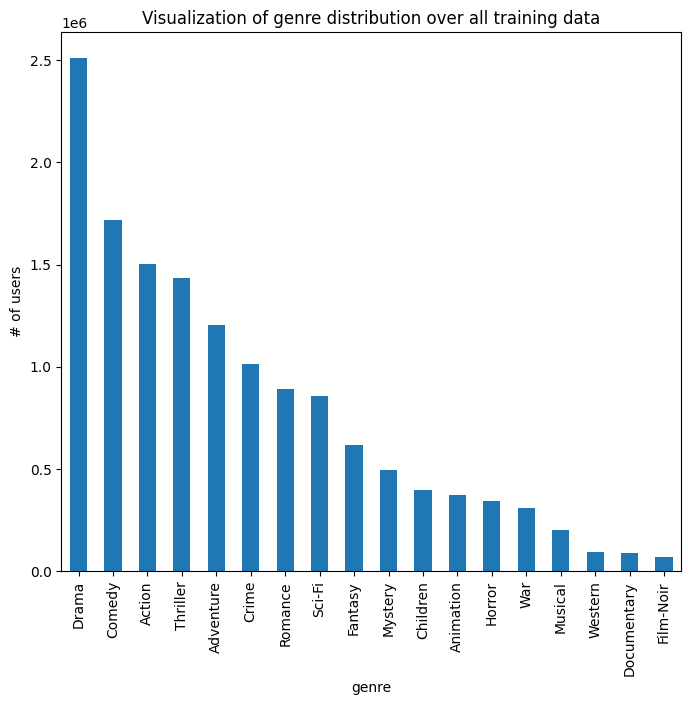

In [40]:
genre_top['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')
plt.show

데이터셋에서 가장 많이 출현하는 장르가 *Drama*, 가장 적게 출현하는 장르가 *Film-Noir*임을 확인할 수 있었습니다.

그러면 전체 training 데이터에서의 genre 분포 뿐만 아니라, genre 데이터 단독의 분포를 출력하면 어떤지 비교해 봅니다. 코드를 실행해주세요.

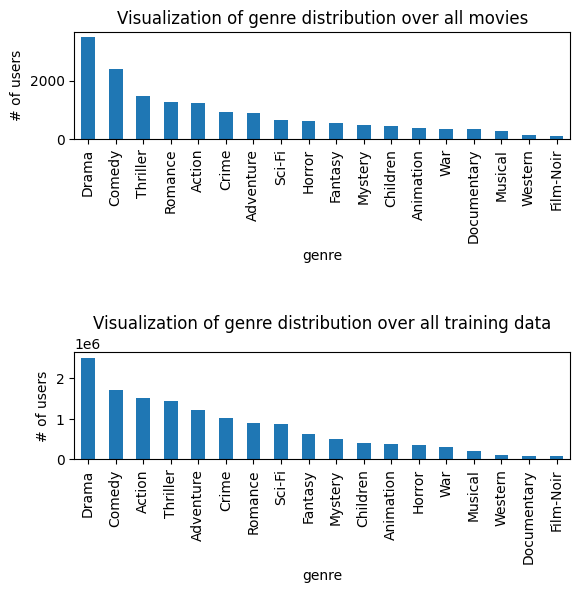

In [41]:
plt.subplot(2,1,1)
genre_data['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all movies')

plt.subplot(2,1,2)
genre_top['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')

plt.subplots_adjust(hspace=2.0, top=1.0)

두 개의 그래프를 확인하면 거의 비슷해보이지만, 두 분포 사이에 작은 차이가 있음을 확인할 수 있습니다. 가령, *Romance* 장르의 영화가 전체 훈련 데이터에서는 7위를 차지하지만, 모든 6807개의 영화 중에서는 4위를 차지합니다. 이는 *Romance* 장르에 해당하는 영화의 갯수에 비해 실제 사용자들이 시청할 확률이 더 높았다는 것을 뜻합니다.

다음은 사용자 한명이 시청한 영화 리스트를 확인하고, 해당 사용자가 가장 선호하는 장르를 순위별로 차트로 알아보겠습니다. 다음 코드에서는 데이터가 가장 많은 사용자의 id인 `active_user_ids[0]`를 사용하겠습니다.
그럼 코드를 실행해보세요!

<AxesSubplot: >

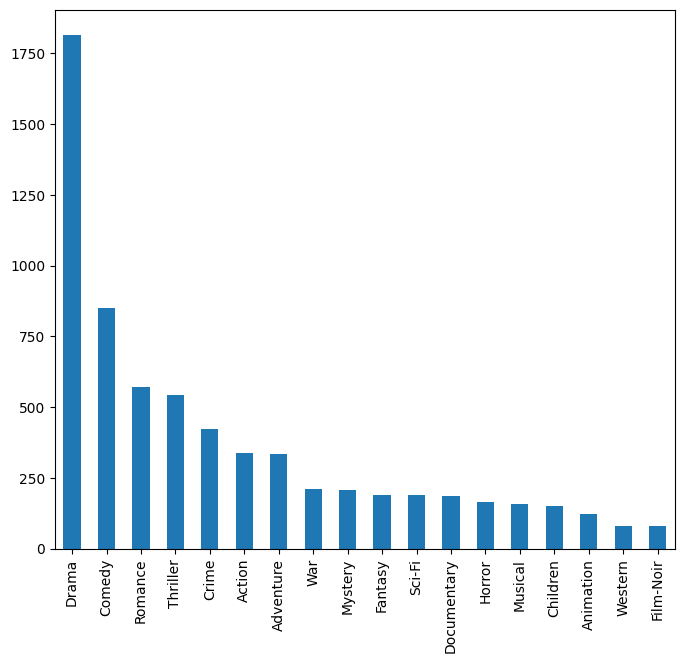

In [42]:
user_id = active_user_ids[0] # specific user id
genre_user = genre_top[genre_top['user'] == user_id]

genre_user['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))

`active_user_ids[0]`에 해당하는 사용자의 시청영화 장르 분포는 전체 데이터의 장르 분포와 크게 차이가 나지 않습니다. 그렇다면 `active_user_ids[1]`에 해당하는 사용자는 어떨까요? 다양한 사용자들의 장르 분포도 한번 비교해 보시기 바랍니다.


다음은 사용자가 주로 언제 영화를 시청했는지 알아보려고 합니다.
그 전에 먼저 간단히 알고 넘어가면 좋은 내용이 있는데요. train 데이터를 보시면 timestamp column은 유닉스 시간(Unix time)을 초 단위로 표시한 것입니다. 통계를 위해 이것을 우리가 알아볼 수 있는 단위로 변환하는 방법을 알아보겠습니다. 다음 코드를 실행해보세요.

In [43]:
import time
unix_time = 1230782529 # some random timestamp from dataset
converted_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(unix_time))

print ("initial unix-based timestamp: %s\nconverted time: %s"%(unix_time, converted_time))

initial unix-based timestamp: 1230782529
converted time: 2009-01-01 04:02:09


파이썬의 time 라이브러리를 사용하여 연-월-일 시간-분-초 단위까지 잘 변환이 되는 것을 확인했습니다. 
하지만 우리 데이터셋의 영화 연도 분포와 task를 고려했을때 시간-분-초 단위는 크게 중요하지 않을 것 같습니다. 일 단위도 빼고, 연-월 단위만 가지고 사용자의 시청 연-월 그래프를 확인해보겠습니다.

즉, 위와 같은 방법으로 timestamp를 변환하여 `active_user_ids[0]`에 해당하는 사용자가 어느 시기에 가장 많은 interaction 활동을 했는지 알아봅니다. 다음 코드를 실행하여 그래프를 확인해봅니다.

/tmp/ipykernel_72517/3998196915.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Statistics of user activity')

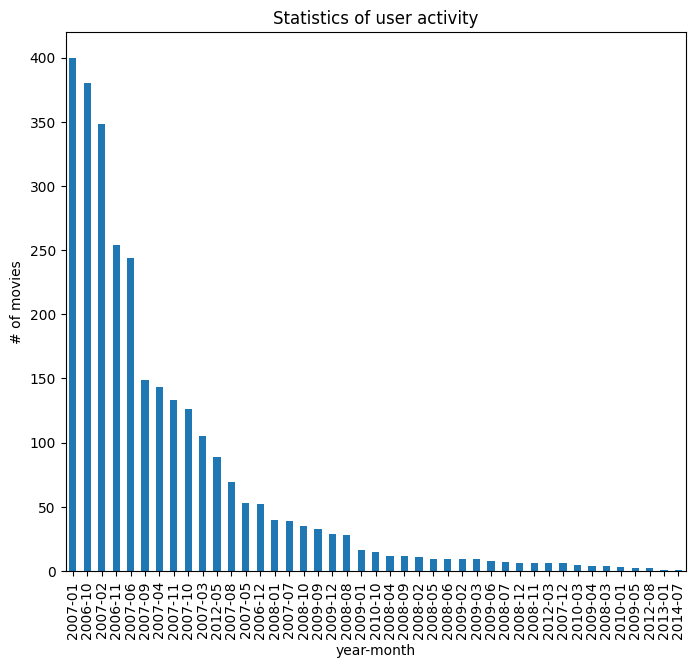

In [44]:
old_df = train_df[train_df['user'] == active_user_ids[0]] # Specific user id
converted_df = old_df

for old_time in old_df['time']:
    new_time = time.strftime('%Y-%m', time.localtime(old_time))
    converted_df['time'] = old_df['time'].replace([old_time], new_time) # replace the time column

converted_df['time'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('year-month')
plt.ylabel('# of movies')
plt.title('Statistics of user activity')

해당 사용자는 대략 2007년 전후로 영화 시청을 가장 많이 했고, 시간이 지나면서 시청 기록이 점점 줄어드는 확인할 수 있습니다.

이어서 사용자가 처음으로 또는 마지막으로 영화 시청을 한 시기도 직접 출력해볼 수 있겠습니다. 또, 다른 사용자들의 분포는 얼마나 다를까요?
혹은, 어떤 영화가 어떤 연도에 가장 많이 소비되었을까요?

눈치 채셨을지 모르겠지만, 앞서 저장했던 *popular_movie_id* 변수는 시각화에 사용되지 않았는데요. 선택 과제로 활용해보시기 바랍니다!

## 마치며

여기까지 오시느라 모두 수고 많으셨습니다. 본 미션에서는 여러 데이터를 관찰하고, 또 분포를 출력해보면서 데이터에 대해 이해하는 시간을 가져보았는데요.
미션에서 제공된 정보 외에도 다른 분석들을 추가로 해보시면 대회를 준비하는데 더 도움이 될 것입니다.
많은 인사이트를 얻어가셔서 대회에 충분히 활용하시길 바라겠습니다!

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.



In [ ]:
[
    {
        "id":369408,
        "color":"BLUE",
        "match_player":[
            {"id":1596325,
            "match_apply_id":2193950,
            "name":"이한성",
            "is_friend":false,
            "back_no":1,
            "fairplay":[],
            "user_id":313776,
            "is_newbie":false,
            "is_leader":0,
            "profile_level":2.6,
            "playstyle":{},
            "is_plaber_of_the_match":false
            },
            {"id":1596366,"match_apply_id":2193951, "name":"정수민","is_friend":false,"back_no":2,"fairplay":[{"id":59231,"name":"무단 불참","point":5,"type_id":3,"memo":null},{"id":59233,"name":"매치 이탈","point":10,"type_id":9,"memo":null},{"id":59234,"name":"운영 비협조","point":0,"type_id":8,"memo":null},{"id":59235,"name":"무성의한 플레이","point":0,"type_id":14,"memo":null}],"user_id":314632,"is_newbie":false,"is_leader":0,"profile_level":1.8,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596370,"match_apply_id":2193708,"name":"박호용","is_friend":false,"back_no":3,"fairplay":[{"id":32508,"name":"지각","point":2,"type_id":12,"memo":null}],"user_id":211877,"is_newbie":false,"is_leader":0,"profile_level":2.5,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596371,"match_apply_id":2193493,"name":"김종린","is_friend":false,"back_no":4,"fairplay":[],"user_id":234619,"is_newbie":false,"is_leader":0,"profile_level":2.5,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596373,"match_apply_id":2194077,"name":"이숭주","is_friend":false,"back_no":5,"fairplay":[],"user_id":318489,"is_newbie":false,"is_leader":0,"profile_level":2.2,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596374,"match_apply_id":2193265,"name":"유태준","is_friend":false,"back_no":6,"fairplay":[{"id":59125,"name":"매치 직전 취소","point":4,"type_id":11,"memo":null}],"user_id":39224,"is_newbie":false,"is_leader":0,"profile_level":2.6,"playstyle":{},"is_plaber_of_the_match":false}],"level":"2.4"},{"id":369409,"color":"RED","match_player":[{"id":1596335,"match_apply_id":2192920,"name":"이감찬","is_friend":false,"back_no":1,"fairplay":[],"user_id":334700,"is_newbie":true,"is_leader":0,"profile_level":null,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596336,"match_apply_id":2192918,"name":"장윤수","is_friend":false,"back_no":2,"fairplay":[],"user_id":75449,"is_newbie":false,"is_leader":0,"profile_level":2.0,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596351,"match_apply_id":2193569,"name":"김준형","is_friend":false,"back_no":3,"fairplay":[],"user_id":291240,"is_newbie":false,"is_leader":0,"profile_level":2.5,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596354,"match_apply_id":2193566,"name":"김경수","is_friend":false,"back_no":4,"fairplay":[],"user_id":297439,"is_newbie":false,"is_leader":0,"profile_level":2.5,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596356,"match_apply_id":2194025,"name":"윤재훈","is_friend":false,"back_no":5,"fairplay":[],"user_id":310889,"is_newbie":false,"is_leader":0,"profile_level":2.6,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596380,"match_apply_id":2194078,"name":"원호","is_friend":false,"back_no":6,"fairplay":[],"user_id":226476,"is_newbie":false,"is_leader":0,"profile_level":2.3,"playstyle":{},"is_plaber_of_the_match":false},{"id":1596381,"match_apply_id":2194072,"name":"장석규","is_friend":false,"back_no":7,"fairplay":[],"user_id":54257,"is_newbie":false,"is_leader":0,"profile_level":2.7,"playstyle":{},"is_plaber_of_the_match":false}],"level":"2.4"},{"id":369410,"color":"YELLOW","match_player":[],"level":null}]